In [335]:
import os 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap

In [204]:
INVENTORY, POLLUTION, BAY = None, None, None
PARENT_DIR = os.getcwd()

In [205]:
def get_sites():
    global INVENTORY
    if INVENTORY is None:
        inventory = gpd.read_file(
            PARENT_DIR + "/data/housing_sites/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp"
        )
        INVENTORY = inventory.to_crs(epsg=3857)
    return INVENTORY

In [206]:
def get_pollution_map():
    global POLLUTION
    if POLLUTION is None:
        pollution = gpd.read_file(
            './data/CalEnviroScreen_4.0Shapefile_D1_2021.shp'
        )
        POLLUTION = pollution.to_crs(epsg=3857)
    return POLLUTION

In [207]:
def get_bay_map():
    global BAY
    if BAY is None:
        bay = gpd.read_file(
            './data/bay_area_map/bay.shp'
        )
        bay['city'] = bay['city'].str.title()
        bay['county'] = bay['county'].str.title()
        BAY = bay.to_crs(epsg=3857)
    return BAY

In [208]:
def get_sites_for(city):
    sites = get_sites().query(f'jurisdict == "{city}"')
    return clean_real_cap(city, sites)

In [209]:
def get_5th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA5"')

In [210]:
def get_4th_cycle_sites_for(city):
    return get_sites_for(city).query('rhnacyc == "RHNA4"')

In [345]:
def get_city_sites_for_cycle(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        return get_4th_cycle_sites_for(city)
    else:
        return get_5th_cycle_sites_for(city)

In [211]:
def get_cities():
    cities_sites = set(get_sites().jurisdict.unique())
    cities_mapped = set(get_bay_map().city.unique())
    #cities_pollution = set(get_pollution_map().City.unique())
    cities = cities_sites.intersection(cities_mapped)
    cities = list(cities)
    cities.sort()
    return cities

In [212]:
def get_pollution_for(city):
    city_shape = get_bay_map().query(f'city == "{city}"')
    city_shape = city_shape[['city', 'geometry']]
    result = gpd.overlay(city_shape, get_pollution_map(), how='intersection', keep_geom_type=False)
    if result.size:
        return result
    return

In [213]:
"""Code lifted from project here: https://github.com/YIMBYdata/housing-elements/blob/main/housing_elements/data_loading_utils.py"""

def clean_real_cap(city, sites):
    sites = sites.copy()
    if city in ('Oakland', 'Los Altos Hills', 'Napa County', 'Newark'):
        sites = remove_range_in_realcap(sites)
    if city in ('Danville', 'San Ramon', 'Corte Madera', 'Portola Valley'):
        sites = remove_units_in_realcap(sites)
    if city == 'El Cerrito':
        sites = fix_el_cerrito_realcap(sites)
    sites['relcapcty'] = pd.to_numeric(sites['relcapcty'], errors='coerce')
    sites = sites.rename({'relcapcty': 'realcap'}, axis=1)
    return sites

def remove_range_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # E.g. Oakland, Newark
    sites.relcapcty = sites.relcapcty.str.split('-').str[-1]
    # Los Altos Hills
    sites.relcapcty = sites.relcapcty.str.split(' to ').str[-1]
    return sites

def remove_units_in_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    # San Ramon
    sites.relcapcty = sites.relcapcty.str.replace('á', '', regex=False)
    # Danville
    sites.relcapcty = sites.relcapcty.str.replace('sfr', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('SFR', '', regex=False)
    sites.relcapcty = sites.relcapcty.str.replace('mfr', '', regex=False)
    # Danville, Corte Madera, Portola Valley
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

def fix_el_cerrito_realcap(sites: pd.DataFrame) -> pd.DataFrame:
    """El Cerrito's realcap is in plain english, listing primary units and accessory units."""
    el_cerrito_rc = []
    for v in sites.relcapcty.values:
        # If realcap includes primary and accessory units
        if isinstance(v, str) and 'primary and' in v:
            # Then let realcap equal double the # of primary units (which is always true)
            v = int(v.split(' ')[0]) * 2
        el_cerrito_rc.append(v)
    sites.relcapcty = el_cerrito_rc
    sites.relcapcty = sites.relcapcty.str.split(' ').str[0]
    return sites

To do: Check that geometry changes after intsection for at least one of the cities that pop up in print_pollution_map_city_incorrect()

In [214]:
def print_pollution_map_city_incorrect():
    """This function shows that census tracts extend beyond a single city."""
    for city in get_cities():
        n_tracts_trivial = sum(get_pollution_map().City == city)
        n_tracts_nontrivial = get_tracts(city).shape[0]
        if n_tracts_trivial != n_tracts_nontrivial:
            print(city, n_tracts_nontrivial - n_tracts_trivial)

In [215]:
def get_production_by_tract(tracts, sites):
    joined = gpd.tools.sjoin(tracts, sites)
    production_by_tract = joined.groupby('Tract').agg({'realcap': sum})
    return production_by_tract

In [231]:
def get_5th_cycle_tracts(city):
    sites = get_5th_cycle_sites_for(city)
    pollution = get_pollution_for(city)
    sites_by_tract = get_production_by_tract(pollution, sites)
    tracts = pollution.set_index('Tract')
    tracts['realcap'] = 0
    tracts.loc[sites_by_tract.index, 'realcap'] = sites_by_tract['realcap']
    tracts['acres'] = tracts['geometry'].to_crs(5070).geometry.area / 10**6 * 247
    tracts['homes per acre'] = tracts['realcap'] / tracts['acres']
    return tracts

In [294]:
tracts_SF = get_5th_cycle_tracts('San Francisco')

Text(0.5, 1.0, 'Are more homes planned for areas with more pollution?')

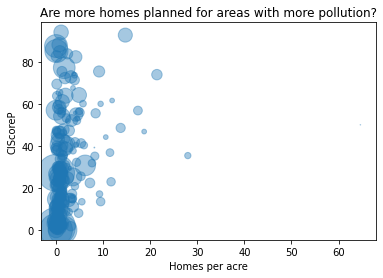

In [295]:
plt.scatter(tracts_SF['homes per acre'], tracts_SF['CIscoreP'], s=tracts_SF['acres'], alpha=.4)
plt.xlabel("Homes per acre")
plt.ylabel("CIScoreP")
plt.title('Are more homes planned for areas with more pollution?')

In [320]:
realcap_by_pctl = tracts_SF.groupby('Pctl_Range').agg({'realcap': sum})
realcap_by_pctl.sort_index(axis=0, key=lambda x: [int(v[0]) for v in x.str.split('-')], inplace=True)

In [322]:
realcap_by_pctl

,realcap
Pctl_Range,
1-5% (lowest scores),1791.0
6-10%,1205.0
11-15%,3180.0
16-20%,1549.0
21-25%,2759.0
26-30%,1453.0
31-35%,940.0
36-40%,1481.0
41-45%,1285.0


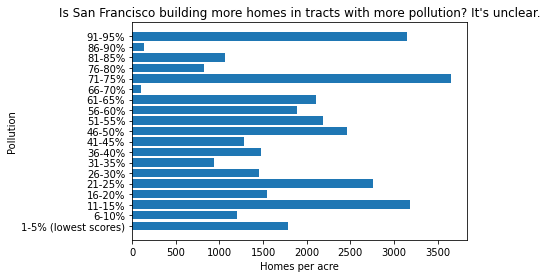

In [332]:
plt.barh(realcap_by_pctl.index, realcap_by_pctl.realcap)
plt.xlabel("Homes per acre")
plt.ylabel("Pollution")
plt.title("Is San Francisco building more homes in tracts with more pollution? It's unclear.")
plt.show()

In [246]:
def score_correlation(city, cycle):
    assert cycle in [4, 5]
    if cycle == 4:
        tracts = get_4th_cycle_tracts('Los Altos')
    else:
        tracts = get_5th_cycle_tracts('Los Altos')
    return pearsonr(tracts['homes per acre'], tracts_LA['CIscoreP'])

In [247]:
score_correlation('Los Altos', 5)

(-0.25365054665247044, 0.2672296403173574)

In [340]:
def plot_pollution_map(city):
    pollution = get_pollution_for(city)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    pollution.plot(ax=ax, column=pollution['CIscoreP'], legend=True, cmap=get_pastel_cmap())
    plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [341]:
def plot_sites_on_top_of_pollution_map(city, cycle):
    pollution = get_pollution_for(city)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams.update({'font.size': 25})
    pollution.plot(ax=ax, column=pollution['CIscoreP'], legend=True, cmap=get_pastel_cmap())
    plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    sites = get_city_sites_for_cycle(city, cycle)
    sites.plot(ax=ax, marker='o', markersize=100, color='steelblue')


In [342]:
def get_pastel_cmap():
    return LinearSegmentedColormap.from_list('pastel', [('#d1ffd1'), ('#ff6961')])

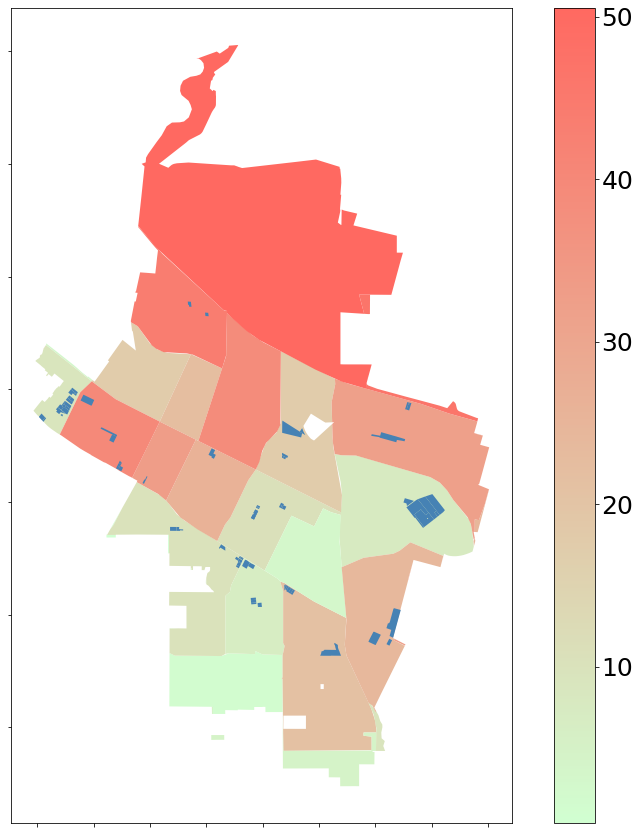

In [343]:
plot_sites_on_top_of_pollution_map('Mountain View', 5)

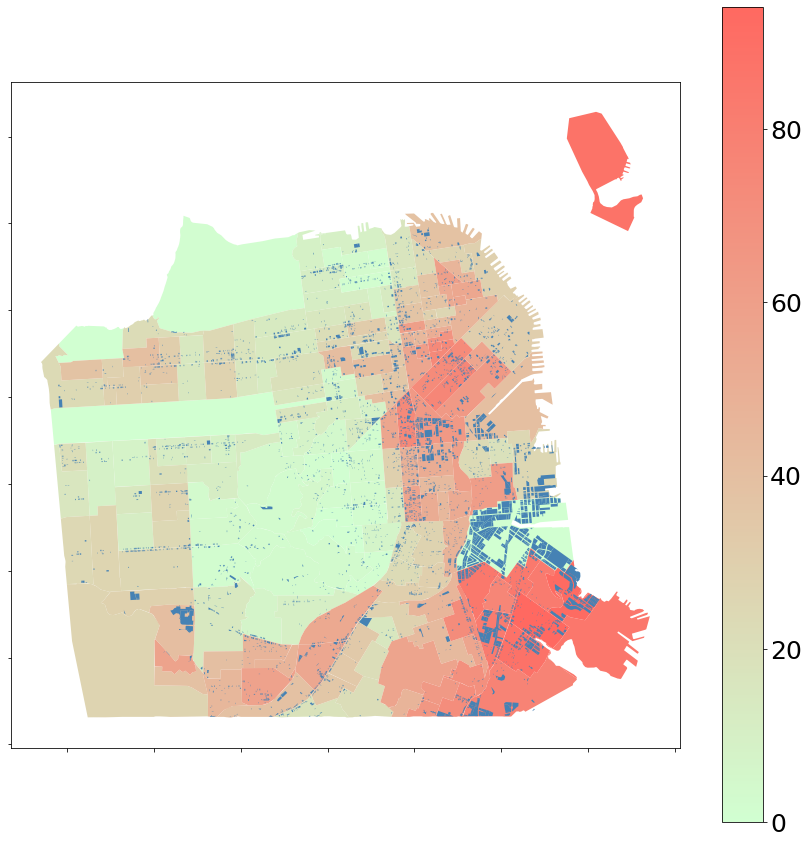

In [344]:
plot_sites_on_top_of_pollution_map('San Francisco', 5)